# Vector Pipeline

## Setting Path

In [1]:
#Import sys to use other file paths in Notebook
import sys
sys.path.append('../Code Files')
sys.path.append('../Data')

## Import Libraries

In [2]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
from optimization import SGD
import pandas as pd
import re
import scipy

## Prepare HCP Data

In [3]:
#Load data from npy file
with open("../Data/fmri_rs.npy", "rb") as f:
  fmri_rs = np.load(f)

#Each sample is a row
fmri_rs = fmri_rs.T

#Get Split to divide into train + test
mat_file = scipy.io.loadmat("../Data/MMP_HCP_60_splits.mat")
seed_1 = mat_file['folds']['seed_1']
subject_lists = seed_1[0, 0]['sub_fold'][0, 0]['subject_list']
test_subjects = [int(item[0]) for item in subject_lists[0,0].flatten()]

#Get HCP test subjects
HCP_753_Subjects = []
with open('../Data/MMP_HCP_753_subs.txt', 'r') as file:
    HCP_753_Subjects = [int(re.sub('\n', '', line)) for line in file.readlines()]

#Put the HCP test subjects into a dataframe
df = pd.read_csv("../Data/MMP_HCP_componentscores.csv")
df['Subject'] = pd.to_numeric(df['Subject'], errors='coerce')
df = df[df['Subject'].isin(HCP_753_Subjects)].reset_index(drop = True)

#Split all our data into a Train and Test Set
df_train, df_test = df[~df['Subject'].isin(test_subjects)], df[df['Subject'].isin(test_subjects)]

In [4]:
#Create train and test arrays
train_subjects = df_train.index.to_list()
test_subjects = df_test.index.to_list()

#Reshape labels into column vector
X_train, Y_train = fmri_rs[train_subjects], df_train["varimax_cog"].to_numpy().reshape((-1, 1))
X_test, Y_test = fmri_rs[test_subjects], df_test["varimax_cog"].to_numpy().reshape((-1, 1))

## Set Global Lambda Parameter for Ridge Regression Tests

In [5]:
#Global Lambda Parameter for Ridge Regression Tests
lamb = 5

## Run Closed Form Solver

In [6]:
from sklearn.linear_model import Ridge

#Create Ridge Model with specific alpha value and fit to (X_train, Y_train)
model = Ridge(alpha = lamb)
model.fit(X_train, Y_train)

#Get Y_train predicted using model weights
Y_train_pred = model.predict(X_train).reshape((-1, 1))
weights = model.coef_.reshape((-1, 1))
W_true = weights

p_star = (np.linalg.norm(Y_train - Y_train_pred) ** 2) + (lamb * (np.linalg.norm(weights) ** 2))
print(f"Value of p^*: {p_star}")

Value of p^*: 38.422065698054055


## Run Experiments

In [7]:
lr = 5e-6
epochs = 25000
batch_size = 64
hypers = {'lambda': lamb, 'lr': lr, 'epochs': epochs, 'batch_size': 64, 'bias': False}
W_estimated, b_estimated, losses, gap_to_optimality, nee_values, nmse_values, corr_values, R2_values = SGD(X = X_train, Y = Y_train, cost_function_code = 1, hypers = hypers, p_star = p_star, W_true = W_true)

Epoch [1/25000], Loss: 2495.4553, Gap to Optimality: 2457.0333, NEE: 1.044928909986368, NMSE: 0.7406527400016785, Correlation: 0.16816613189148608, R2: 0.005265617506736264
Epoch [2/25000], Loss: 2465.7439, Gap to Optimality: 2427.3218, NEE: 1.0443916139351106, NMSE: 0.7318270802497864, Correlation: 0.17777270928856836, R2: 0.01711882405630971
Epoch [3/25000], Loss: 2442.2007, Gap to Optimality: 2403.7786, NEE: 1.0438740966241724, NMSE: 0.7248353958129883, Correlation: 0.19214785387649716, R2: 0.026509071555335106
Epoch [4/25000], Loss: 2458.0571, Gap to Optimality: 2419.6351, NEE: 1.0431280985396745, NMSE: 0.7295441627502441, Correlation: 0.2012970816692335, R2: 0.020184924571931218
Epoch [5/25000], Loss: 2433.9124, Gap to Optimality: 2395.4903, NEE: 1.0427602538909126, NMSE: 0.7223734855651855, Correlation: 0.21178597916670142, R2: 0.029815453349051335
Epoch [6/25000], Loss: 2438.8779, Gap to Optimality: 2400.4559, NEE: 1.0422155545476497, NMSE: 0.7238489985466003, Correlation: 0.233

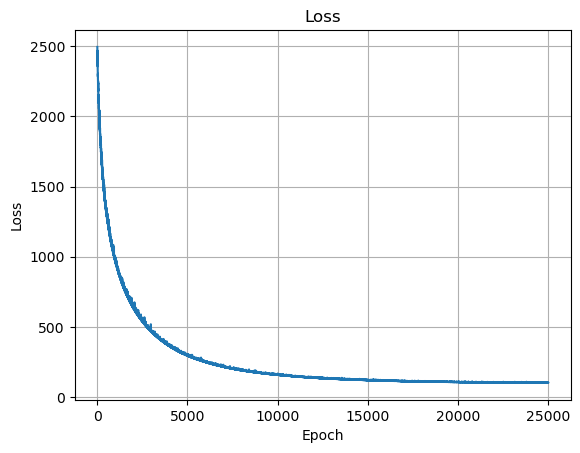

In [8]:
plt.plot(range(1, len(losses)+1), losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

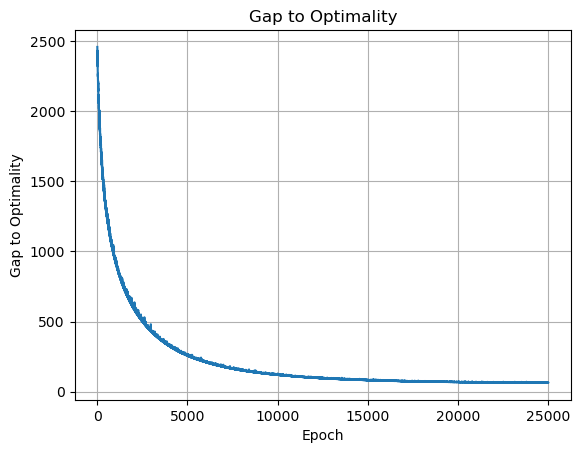

In [9]:
plt.plot(range(1, len(gap_to_optimality)+1), gap_to_optimality)
plt.title('Gap to Optimality')
plt.xlabel('Epoch')
plt.ylabel('Gap to Optimality')
plt.grid(True)
plt.show()

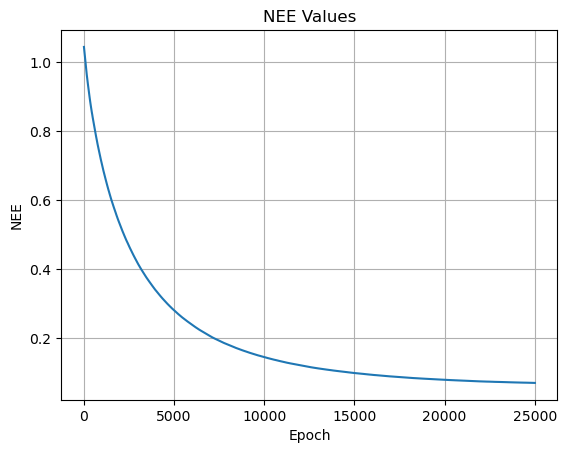

In [10]:
plt.plot(range(1, len(nee_values)+1), nee_values)
plt.title('NEE Values')
plt.xlabel('Epoch')
plt.ylabel('NEE')
plt.grid(True)
plt.show()

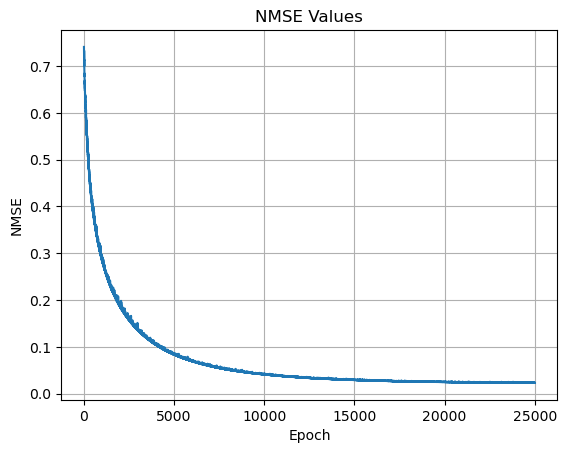

In [11]:
plt.plot(range(1, len(nmse_values)+1), nmse_values)
plt.title('NMSE Values')
plt.xlabel('Epoch')
plt.ylabel('NMSE')
plt.grid(True)
plt.show()

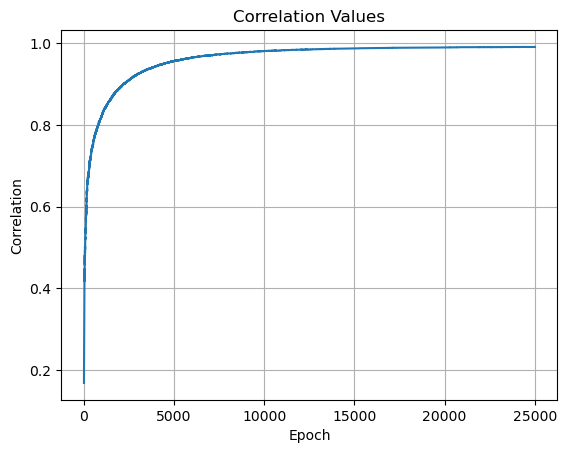

In [12]:
plt.plot(range(1, len(corr_values)+1), corr_values)
plt.title('Correlation Values')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

In [13]:
plt.plot(range(1, len(R2_values)+1), R2_values)
plt.title('R2 Values')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.grid(True)
plt.show()